In [0]:
!pip uninstall keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git
!pip install keras-metrics

Uninstalling Keras-Preprocessing-1.1.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras_Preprocessing-1.1.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/keras_preprocessing/*
Proceed (y/n)? y
  Successfully uninstalled Keras-Preprocessing-1.1.0
  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-prd35hl5
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-prd35hl5
  Stored in directory: /tmp/pip-ephem-wheel-cache-7rj7s2x0/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


In [0]:
import numpy as np
import tensorflow as tf
from PIL import Image
from google.colab.patches import cv2_imshow
import os
import cv2
import re
import pandas as pd
import keras
from keras import backend as K
from keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.image import load_img
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_metrics as km
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
#parameters
batch_size = 1

In [0]:
save_path = '/content/drive/My Drive/Colab Notebooks/ML projekat/best_model.{epoch:02d}-{val_loss:.2f}.h5'

In [0]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/ML projekat/data/train_data/train'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/ML projekat/data/validation_data/validation'
test_data_dir = '/content/drive/My Drive/Colab Notebooks/ML projekat/data/test_data/test'


In [0]:
# show image and prediction for a single image
def predict_genre(model, img):
  # resize for presentation                                  
  plt.imshow(img)
  
  # get probabilities
  probabilities = model.predict(img.reshape(1, 224, 224, 3))
  print(probabilities)
  # keep the best 3
  top_3 = np.argsort(probabilities)[0][-3:]
  
  for i in range(0, 3):
    print(genres[top_3[i]] + '({})'.format(probabilities[0, top_3[i]]))

In [0]:
def get_all_genres(dataset) :
    new_ds = dataset['Genre'].str.split("|", expand=True)

    genres1 = set(new_ds[0])
    genres2 = set(new_ds[1])
    genres3 = set(new_ds[2])

    genres = genres1 | genres2 | genres3

    genres.remove(None)
    genres = list(genres)
    return np.array(genres, dtype=object)

In [0]:
# extracts a year from the movie title
def extractYear(title) :
  try:
    return int(re.search('\(([^)]+)', title).group(1))
  except (ValueError, AttributeError): 
    return None

In [0]:
def genres_to_bool(y):
  y = np.array(y, dtype=object)
  genres_arr = np.array(genres, dtype=object)
  if (len(y) == 1) :
    return np.equal(genres_arr, y[0]) + np.array([0])
  elif (len(y) == 2):
    first = np.equal(genres_arr, y[0])
    second = np.equal(genres_arr, y[1])
    return np.logical_or(first, second) + np.array([0])
  elif (len(y) == 3):
    first = np.equal(genres_arr, y[0])
    second = np.equal(genres_arr, y[1])
    third = np.equal(genres_arr, y[2])
    return np.logical_or(first, np.logical_or(second, third)) + np.array([0])

In [0]:
# returns the number of missclasified labels
def hamming_loss(y, y_hat):
  y_bool = K.cast(y, dtype=bool)
 
  y_hat_bool = y_hat > 0.5
  y_hat_bool = K.cast(y_hat_bool, dtype=bool)
  
  xor = tf.math.logical_xor(y_bool, y_hat_bool)
  
  xor = K.cast(xor, dtype=tf.float32)
 
  return K.mean(xor)

In [0]:

# returns if the top ranked label is not among the proper labels
def one_error_loss(y, y_hat):  
  # sum of mistakes
  mistakes = 0
  # for each instance
  for j in range(0, batch_size): 
    # top ranked label position
    top_ranked_label = tf.math.top_k(y_hat[j], k=1, sorted=True).indices[0]
    # cast to int32
    top_ranked_label = tf.cast(top_ranked_label, dtype=tf.int32)
    # find the proper label on that position
    label = tf.gather(y[j], top_ranked_label)
   
    m = K.switch(K.equal(label, 1), 0, 1)
    mistakes+=m
 
  return mistakes / batch_size  

In [0]:
# returns how far we need to go down the list
# of labels to cover all proper labels
def coverage(y, y_hat) :
  y = K.cast(y, dtype=tf.int32)
    
  # sorted indices of prediction values
  sorted_prediction = tf.math.top_k(y_hat, k=y_hat.shape[-1], sorted=True).indices
    
  sorted_prediction = K.cast(sorted_prediction, dtype=tf.int64)
  
  # sum of distances
  dist_sum = 0;
  
  # for every instance
  for j in range(0, batch_size) :
    
    # position of ones in proper labels
    ones_pos = tf.where(tf.equal(y[j], 1))    

    distances = tf.map_fn(lambda x: tf.where(tf.equal(x, sorted_prediction[j])) + 1, ones_pos)
    dist_sum += K.max(distances)
  
  return dist_sum / batch_size

In [0]:
# read dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML projekat/MovieGenre.csv')

In [0]:
# drop all rows with null values
dataset.dropna(inplace=True)

In [0]:
# adds year column
dataset['Year'] = dataset['Title'].apply(extractYear)

In [0]:
# reduce the dataset to movies in the past 10 years
dataset = dataset.drop(dataset[dataset.Year < 2000].index)

In [0]:
# drop duplicates in terms of imdbId
print(dataset.shape)
dataset.drop_duplicates(['imdbId'], keep='last',inplace=True)
print(dataset.shape)

(20593, 7)
(20162, 7)


In [0]:
# change imdbId to str
dataset['imdbId'] = dataset['imdbId'].astype(str)
dataset['imdbId'] = dataset['imdbId'] + '.jpg'

In [0]:
# add list of genres as a column
dataset['Genre_modified'] =  dataset['Genre'].str.split("|", expand=False)

In [0]:
# get a numpy array of all possible genres
genres = get_all_genres(dataset)
genres = genres.tolist()
genres.sort()
#genres = ['Biography', 'Family', 'Horror', 'War', 'Talk-Show', 'Drama', 'Documentary', 'History', 'Reality-TV', 'Music', 'Adult', 'Western', 'News', 'Crime', 'Animation', 'Mystery', 'Romance', 'Comedy', 'Adventure', 'Thriller', 'Game-Show', 'Action', 'Short', 'Musical', 'Sci-Fi', 'Sport', 'Fantasy']
print(genres)

['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']


In [0]:
# create labels column
dataset['Labels'] = dataset['Genre_modified'].apply(genres_to_bool).tolist()
dataset.head(5)


,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year,Genre_modified,Labels
27,114117.jpg,http://www.imdb.com/title/tt114117,Persuasion,7.7,Drama,https://images-na.ssl-images-amazon.com/images...,NaN,[Drama],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
566,111709.jpg,http://www.imdb.com/title/tt111709,Wide-Eyed and Legless,7.3,Comedy|Crime|Drama,https://images-na.ssl-images-amazon.com/images...,NaN,"[Comedy, Crime, Drama]","[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
774,113147.jpg,http://www.imdb.com/title/tt113147,The Gate of Heavenly Peace,8.8,Documentary,https://images-na.ssl-images-amazon.com/images...,NaN,[Documentary],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1505,112951.jpg,http://www.imdb.com/title/tt112951,En avoir (ou pas) (1995),6.8,Drama|Romance,https://images-na.ssl-images-amazon.com/images...,NaN,"[Drama, Romance]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2174,87690.jpg,http://www.imdb.com/title/tt87690,The Master,4.3,Adventure|Drama|Action,https://images-na.ssl-images-amazon.com/images...,NaN,"[Adventure, Drama, Action]","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [0]:
# split labels
dataset = pd.merge(dataset, pd.DataFrame(dataset.Labels.tolist(), columns=genres), on=dataset.index)


In [0]:
dataset.head(5)

,key_0,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year,Genre_modified,Labels,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,27,114117.jpg,http://www.imdb.com/title/tt114117,Persuasion,7.7,Drama,https://images-na.ssl-images-amazon.com/images...,NaN,[Drama],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,566,111709.jpg,http://www.imdb.com/title/tt111709,Wide-Eyed and Legless,7.3,Comedy|Crime|Drama,https://images-na.ssl-images-amazon.com/images...,NaN,"[Comedy, Crime, Drama]","[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,774,113147.jpg,http://www.imdb.com/title/tt113147,The Gate of Heavenly Peace,8.8,Documentary,https://images-na.ssl-images-amazon.com/images...,NaN,[Documentary],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1505,112951.jpg,http://www.imdb.com/title/tt112951,En avoir (ou pas) (1995),6.8,Drama|Romance,https://images-na.ssl-images-amazon.com/images...,NaN,"[Drama, Romance]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2174,87690.jpg,http://www.imdb.com/title/tt87690,The Master,4.3,Adventure|Drama|Action,https://images-na.ssl-images-amazon.com/images...,NaN,"[Adventure, Drama, Action]","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


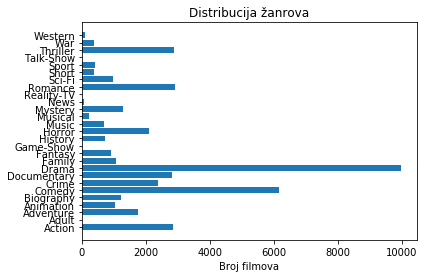

In [0]:
# create distribution of genres plot
sums = dataset.iloc[0:][genres].sum(axis=0)
y_pos = np.arange(len(genres))

plt.barh(y_pos, sums, height = 0.8, align='center')
plt.yticks(y_pos, genres)
plt.xlabel('Broj filmova')
plt.title('Distribucija žanrova')

plt.rcParams['figure.figsize'] = (7,7)

plt.show()

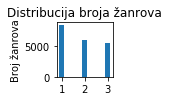

In [0]:
# create distribution of number of genres plot
counts = dataset.iloc[0:][genres].sum(axis=1).value_counts()
x_pos = np.array([1, 2, 3])
values = np.array([counts[3], counts[2], counts[1]])

plt.rcParams['figure.figsize'] = (1,1)
plt.bar(x_pos, values, width=0.2, align='center')
plt.xticks(x_pos, x_pos)
plt.ylabel("Broj žanrova")

plt.title("Distribucija broja žanrova")

plt.show()

In [0]:
# data generators
datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator=datagen.flow_from_dataframe(dataframe=dataset, directory=train_data_dir, 
                                            x_col="imdbId", y_col=genres, class_mode='raw',
                                            target_size=(224,224), batch_size=batch_size)

valid_generator=datagen.flow_from_dataframe(dataframe=dataset, directory=validation_data_dir, 
                                            x_col="imdbId", y_col=genres, class_mode="raw",
                                            target_size=(224,224), batch_size=batch_size)

test_generator=datagen.flow_from_dataframe(dataframe=dataset, directory=test_data_dir, 
                                            x_col="imdbId", y_col=genres, class_mode="raw",
                                            target_size=(224,224), batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 8557 invalid image filename(s) in x_col="imdbId". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 11605 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 16297 invalid image filename(s) in x_col="imdbId". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3865 validated image filenames.
Found 3861 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 16301 invalid image filename(s) in x_col="imdbId". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
# model definition
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(genres), activation='sigmoid'))

W0617 14:56:04.647709 140290231220096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 14:56:04.674123 140290231220096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 14:56:04.681719 140290231220096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 14:56:04.698159 140290231220096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0617 14:56:04.702114 140290231220096 deprecation_wrapp

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
__________

In [0]:
adam = optimizers.Adam(lr=0.0001, clipnorm=1.)
# model compile
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', hamming_loss, one_error_loss, coverage])

W0617 14:13:00.853490 139646675896192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0617 14:13:00.859144 139646675896192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0617 14:13:00.863848 139646675896192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("dense_3/Sigmoid:0", shape=(?, 27), dtype=float32)


In [0]:
mc = ModelCheckpoint(save_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [0]:
hist = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[mc],
                    epochs=10)

In [0]:
# plot losses
plt.rcParams['figure.figsize'] = (7,7)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Treniranje modela')
plt.ylabel('Funkcija gubitka')
plt.xlabel('epoha')
plt.legend(['trening skup', 'validacioni skup'], loc='upper left')
plt.show()

In [0]:
# load the best model
best_model_path = "/content/drive/My Drive/Colab Notebooks/ML projekat/best_model.03-0.21.h5"
saved_model = load_model(best_model_path, custom_objects={ 'hamming_loss': hamming_loss, 'one_error_loss': one_error_loss, 'coverage' : coverage})

W0617 15:05:08.210376 140290231220096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 15:05:09.127463 140290231220096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0617 15:05:09.140330 140290231220096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("dense_2_1/Sigmoid:0", shape=(?, 27), dtype=float32)


In [0]:
# evaluate on the test set
_, test_accuracy, test_hamming_loss, test_one_error_loss, test_coverage = saved_model.evaluate_generator(test_generator, steps = STEP_SIZE_TEST)
print("Testing accuracy: {} \tTesting Hamming loss:{} \tTesting one-error loss: {} \tTesting coverage: {}".format(test_accuracy, test_hamming_loss, test_one_error_loss, test_coverage))

Testing accuracy: 0.9246788906699108 	Testing Hamming loss:0.07532111291547601 	Testing one-error loss: 0.47966847966847964 	Testing coverage: 7.548303548303548
